# Simple forecasting with a neural network

**Author**: [Mariana Clare](https://www.ecmwf.int/en/about/who-we-are/staff-profiles/mariana-clare)

*This notebook was last tested and operational on 14/04/2025. Please [report any issues](https://github.com/ecmwf-training/ml-examples/issues).*

:::{admonition} About
:class: note, dropdown
This notebook was originally created for ECMWF's [MOOC on Machine Learning in Weather and Climate](https://learning.ecmwf.int/course/index.php?categoryid=1), and has been lightly updated and tested for the purposes of this collection of examples. The original notebook can be found [here](https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_1/weatherbench.ipynb).
:::

:::{admonition} Running this notebook
:class: tip, dropdown
This notebook can be run/accessed on the following free online platforms. Please note they are not officially supported by or linked with ECMWF. See [Running the notebooks](sec:running_notebooks) for more details.

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/ml-examples/blob/develop/ex_Simple_Forecasting.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/ml-examples/blob/develop/ex_Simple_Forecasting.ipynb)
[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/ml-examples/develop?labpath=ex_Simple_Forecasting.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/ml-examples/blob/develop/ex_Simple_Forecasting.ipynb)
:::

## Introduction


This notebook demonstrates how to build a simple neural network to predict the 500hPa geopotential height (z500) using the [WeatherBench](https://sites.research.google/weatherbench/) dataset. The z500 variable is crucial for identifying large-scale weather systems like cyclones and anticyclones.

In this notebook we'll take the following steps:

- We'll use the WeatherBench dataset, a benchmark dataset specifically designed for evaluating machine learning models in weather forecasting.
- We'll build a simple Convolutional Neural Network (CNN), a type of neural network well-suited for handling spatial data like weather maps.
- We'll train the model on historical z500 data and assess its performance against baseline methods like persistence and climatology.
- We'll visualize the model's predictions and compare them to the ground truth and baseline forecasts.

With the data you will download, you can make a forecast for any number of days ahead, but in this exercise we focus on forecasting the geopotential five days ahead.

We evaluate our model using the Root Mean Squared Error.

## Prepare your environment

Dependencies for this example are given in the [environment.yml](https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_1/environment.yml) file. 

We begin by importing the required packages: these include [numpy](https://numpy.org/doc/stable/) and [xarray](https://docs.xarray.dev/en/stable/), which are used for handling multidimentional arrays of data. They also include [tensorflow](https://www.tensorflow.org/) which is a popular Machine Learning package.

In [2]:
# Import packages
import xarray as xr
import numpy as np

## Load in the necessary python packages to train a neural network

import tensorflow.keras as keras
import tensorflow as tf

## Download data

Next we need to download the WeatherBench data from the public repository. We will download a pre-prepared data set of the 500hPa geopotential data at 5.625 degrees, because training on the whole benchmark dataset using colab would take a very long time and is thus beyond the scope of this exercise.

*Note: this download may take over 20 minutes.*

In [3]:
try:
    !wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/geopotential_500_5.625deg.zip
except:
    !wget --no-check-certificate "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500_5.625deg.zip

--2025-04-07 11:07:51--  https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/geopotential_500_5.625deg.zip
Resolving get.ecmwf.int (get.ecmwf.int)... 136.156.238.204
Connecting to get.ecmwf.int (get.ecmwf.int)|136.156.238.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1532774663 (1.4G) [application/zip]
Saving to: ‘geopotential_500_5.625deg.zip’

geopotential_500_5. 100%[===================>]   1.43G  20.6MB/s    in 2m 10s  

2025-04-07 11:10:02 (11.2 MB/s) - ‘geopotential_500_5.625deg.zip’ saved [1532774663/1532774663]



As the data arrives in a zip file, we unzip it.

In [4]:
# Unzip the data
!unzip geopotential_500_5.625deg.zip

Archive:  geopotential_500_5.625deg.zip
  inflating: geopotential_500hPa_1979_5.625deg.nc  
  inflating: geopotential_500hPa_1980_5.625deg.nc  
  inflating: geopotential_500hPa_1981_5.625deg.nc  
  inflating: geopotential_500hPa_1982_5.625deg.nc  
  inflating: geopotential_500hPa_1983_5.625deg.nc  
  inflating: geopotential_500hPa_1984_5.625deg.nc  
  inflating: geopotential_500hPa_1985_5.625deg.nc  
  inflating: geopotential_500hPa_1986_5.625deg.nc  
  inflating: geopotential_500hPa_1987_5.625deg.nc  
  inflating: geopotential_500hPa_1988_5.625deg.nc  
  inflating: geopotential_500hPa_1989_5.625deg.nc  
  inflating: geopotential_500hPa_1990_5.625deg.nc  
  inflating: geopotential_500hPa_1991_5.625deg.nc  
  inflating: geopotential_500hPa_1992_5.625deg.nc  
  inflating: geopotential_500hPa_1993_5.625deg.nc  
  inflating: geopotential_500hPa_1994_5.625deg.nc  
  inflating: geopotential_500hPa_1995_5.625deg.nc  
  inflating: geopotential_500hPa_1996_5.625deg.nc  
  inflating: geopotentia

We now load the geopotential height data from the downloaded NetCDF files. In the following, we open all files matching the pattern `'geopotential_500*.nc'`, combining them into a single dataset, and then selecting data every 12 hours to reduce the data size and speed up processing. The resulting dataset is stored in the variable `z500`.

In [5]:
z500 = xr.open_mfdataset('geopotential_500*.nc', combine='by_coords').isel(time=slice(None, None, 12))
z500

<xarray.Dataset> Size: 240MB
Dimensions:  (time: 29220, lat: 32, lon: 64)
Coordinates:
    level    int32 4B 500
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 234kB 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 239MB dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

Next, we load the data into memory - this will speed up data acccess and processing.

In [6]:
# Now we can load the data into memory to speed up accessing data. This should take <30s
z500.load()

<xarray.Dataset> Size: 240MB
Dimensions:  (time: 29220, lat: 32, lon: 64)
Coordinates:
    level    int32 4B 500
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 234kB 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 239MB 5.156e+04 5.158e+04 ... 4.864e+04
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

We can visualise the data by plotting the geopotential at a single time point. We select the first time point, but try selecting others.

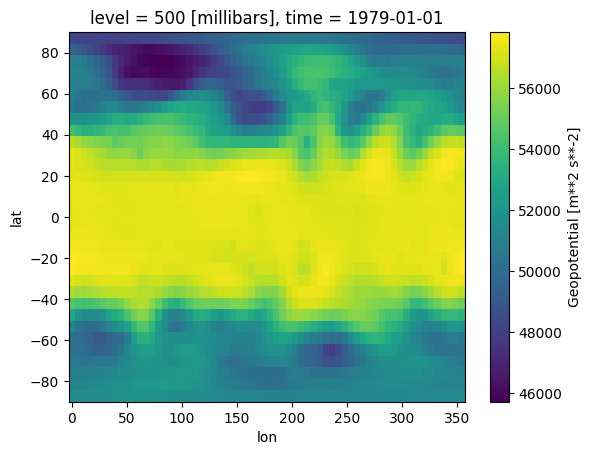

In [7]:
# Plot the geopotential at an example date-time
z500.z.isel(time=0).plot();

## Compute baselines

In this section we calculate two *baseline* forecasts: the persistence forecast and the climatology, which are intentionally simple methods that serve as benchmarks to evaluate the performance of the CNN model.

To implement this, we begin by creating slice objects which define the years we will allocate to training (1979-2015), validation (2016) and testing (2017-2018).

In [8]:
# training dataset selection
train_years = slice('1979', '2015')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2016', '2016')
# test dataset selection
test_years = slice('2017', '2018')

Next we define a function which, given the forecast `fc` and the ground truth `gt` (the observed values), calculates the area-averaged root mean-squared error. This effectively provides an overall error metric in our forecast, but accounts for the fact that grid points near the poles cover less area than grid points near the equator. This is crucial for getting a fair measure of forecast accuracy across the globe. Later, the objective will be to find the neural networks parameters that *minimise* this error.

In [9]:
def computed_weighted_rmse(fc, gt):
  """Error metric to compute the area averaged RMSE."""
  error = fc - gt
  weights_lat = np.cos(np.deg2rad(error.lat))
  weights_lat /= weights_lat.mean()
  rmse = np.sqrt(((error)**2 * weights_lat).mean(('time', 'lat', 'lon')))
  return rmse

Next, we calculate the *persistence forecast*, which is a simple baseline prediction that assumes the future weather will be the same as the current weather.

To do this, we use the test data, and shift it five days forward. At the same time, we extract `target`, the observed data in the test period, and calculate the (weighted) RMSE for the persistence forecast using the function defined previously.

In [10]:
# pick the forecast lead time
lead_time_steps = 10 # 5 day forecast because considering midday and midnight

# compute persistent forecast
persistence_fc = z500.sel(time=test_years).isel(time=slice(0, -lead_time_steps))
persistence_fc['time'] = persistence_fc.time + np.timedelta64(5, 'D').astype('timedelta64[ns]')

# target data
target = z500.sel(time=test_years)['z']
# compute RMSE
computed_weighted_rmse(persistence_fc, target)

<xarray.Dataset> Size: 12B
Dimensions:  ()
Coordinates:
    level    int32 4B 500
Data variables:
    z        float64 8B 1.034e+03

Our other baseline forecast is the *climatology*, which is the average value (over all years in the training data) of `z500` for each day of the year. We calculate this simply by grouping by the day of the year, and taking the mean for each day.

In [11]:
clim = z500.sel(time=train_years).groupby('time.dayofyear').mean()
# compute RMSE
computed_weighted_rmse(clim.sel(dayofyear=z500.sel(time=test_years).time.dt.dayofyear), z500)

<xarray.Dataset> Size: 12B
Dimensions:  ()
Coordinates:
    level    int32 4B 500
Data variables:
    z        float64 8B 819.9

At this point, we have computed two baseline forecasts, and resulting errors, which we will now use as comparisons for our CNN approach.

## Train a simple CNN

Now we will train a simple convolutional neural network (CNN) forecasting model. We will use Keras for this, but before training the model we need to prepare the data. This involves the following steps:

- Splitting the data into training, validation and test steps using the year ranges defined previously
- Normalising the data using the mean and standard deviation (importantly the mean and standard deviation are calculated only on the training data to avoid data leakage)
- Creating input and output data sets by shifting the data based on the lead times

The last step here merits some further explanation. Our aim is to forecast z500 based on previous values of z500, so the inputs (X) are the previous values, and the outputs (Y) are the future values to forecast. The inputs (X) are therefore created by shifting the data back in time by `lead_steps` relative to the outputs (Y). This is done to create a forecasting scenario where the model learns to predict the future (Y) based on past observations (X). For example, if `lead_steps` is 10, the model will try to predict the geopotential height 10 time steps ahead using the current geopotential height as input.

All of these operations are wrapped in the following function which outputs the training, validation and test data sets.

In [ ]:
def get_train_valid_test_dataset(lead_steps, z500_dataset):
  # Split train, valid and test dataset
  train_data = z500_dataset.sel(time=train_years)
  valid_data = z500_dataset.sel(time=valid_years)
  test_data = z500_dataset.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  mean = mean['z'].values # extract numerical value from xarray Dataset
  std = std['z'].values # extract numerical value from xarray Dataset

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  X_test = test_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

We now run our function on our data and with the previously-defined lead time. The outputs here report the shapes of the resulting arrays.

In [13]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, z500)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(27018, 32, 64, 1)
(27018, 32, 64, 1)
(722, 32, 64, 1)
(722, 32, 64, 1)
(1450, 32, 64, 1)
(1450, 32, 64, 1)


### Define model

With our data fully prepared we now need to define the neural network that we will train. We will build a convolutional neural network (CNN) in [Keras](https://keras.io/examples/vision/mnist_convnet/). CNNs are a type of neural network commonly used for image processing, but they are also effective for other types of data with spatial relationships, like weather data in this case.

To define the CNN we use the "sequential" approach in Keras, which is a linear stack of layers, where the output of one layer becomes the input to the next. Our CNN is defined as having three convolutional layers `Conv2D()` (extracting features from the input data and preceding layers), separated by *Exponential Linear Unit* activation functions `ELU()` (introducing nonlinearity, in order to be able to learn complex patterns).

In [14]:
# CNN

model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same'),   # 32 channels with a 5x5 convolution
    keras.layers.ELU(),  # Slightly smoother alternative to ReLU
    keras.layers.Conv2D(32, 5, padding='same'),   # Same padding keeps the size identical.
    keras.layers.ELU(),
    keras.layers.Conv2D(1, 5, padding='same'),
    # No activation since we are solving a regression problem
])

Next we need to build the model using an example batch and compile it. We pass a sample of our training data to the model so that it understands what kind of input data to expect. Next, the model is compiled, specifying that we will use the standard [Adam optimizer](https://arxiv.org/abs/1412.6980) combined with a Mean Squared Error Loss.

In [15]:
model.build(X_train[:32].shape)
model.compile(keras.optimizers.Adam(1e-4), 'mse')

We will summarise our model at this point to check it agrees with our expectations.

In [16]:
# With .summary() we can check the shape of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 64, 32)            │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (32, 32, 64, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 32, 64, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (32, 32, 64, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 32, 64, 1)             │             801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,265 (106.50 KB)

 Trainable params: 27,265 (106.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train model

With the data prepared and the model fully specified, we can now train the model. Recall that this involves iteratively adjusting the model parameters to minimise the error between the model predictions and the training data. The `batch_size` argument specifies that the data is passed in batches of 32 samples before each update of the model parameters. The `epochs` argument specifies that the training data will be passed to the model a total of 15 times - each time the batch order is shuffled, and this helps to improve the parameter optimisation.

In [17]:
# Finally we can fit the model.
# For each epoch, the entire training dataset has passed through the neural network exactly once
# Each epoch should take about 10s

model.fit(X_train, Y_train, batch_size=32, epochs=15)

Epoch 1/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0651
Epoch 2/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0027
Epoch 3/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0023
Epoch 4/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0020
Epoch 5/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0019
Epoch 6/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017
Epoch 7/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017
Epoch 8/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016
Epoch 9/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016
Epoch 10/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016
Epoch 11/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016
Epoch 12/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016
Epoch 13/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016
Epoch 14/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0016
Epoch 15/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - l

### Evaluate model

Here we have to do a bit of wrangling to get the model predictions into the same format (xarray) as the test data. This will allow us to easily evaluate the model performance. To do this we feed our test inputs `X_test` into the model to obtain corresponding predictions (forecasts) `pred_test`. 

In [18]:
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model.predict(X_test).squeeze()   # To remove channel dimension which is 1

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


For network training we normalized the data by subtracting the mean and dividing by the standard deviation. To evaluate the predictions, we now need to un-normalize the data using the mean and standard deviation we used to normalize it. Then we can compute the RMSE of the predictions.

In [19]:
# Unnormalize
pred_test = pred_test * std + mean
# compute RMSE
computed_weighted_rmse(pred_test, target.isel(time=slice(lead_time_steps, None)))

<xarray.DataArray ()> Size: 8B
array(851.20894363)
Coordinates:
    level    int32 4B 500

How does the skill compare to the climatology?

### Visualise results

It is always important to visualize your model's predictions - this may often reveal things that are not evident from summary statistics such as the RMSE. Here we take a time `t` from the test period and visualize the ground truth (the observed data), the climatology and the neural network's predictions.

Text(0.5, 1.0, 'Prediction')

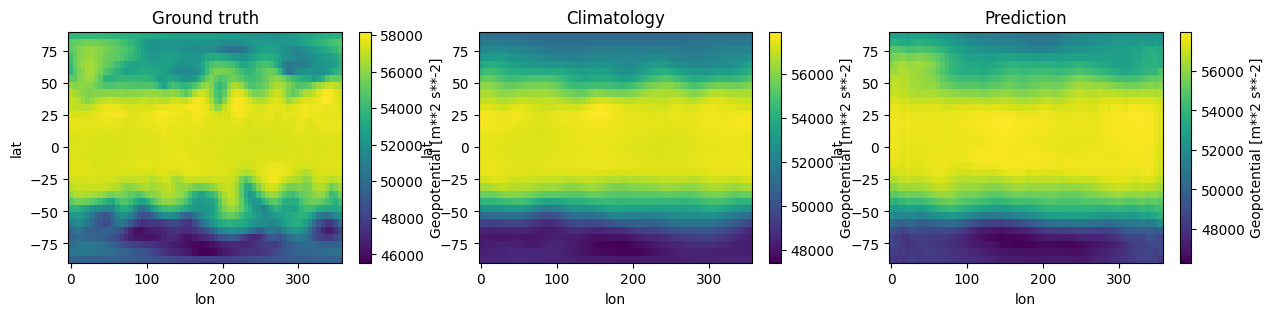

In [20]:
# Note first you need to modify your predictions so they are an xarray instead of a numpy array
# This way you can access the latitude, longitude and time for each point in the array

# We do this by taking a copy of the original z500 object which has the correct time,
# latitude and longitude, and replacing the data in this array with the predictions
pred_xarray = z500.z.sel(time=test_years).isel(time=slice(lead_time_steps, None)).copy()
pred_xarray.data = pred_test

import matplotlib.pyplot as plt

t = xr.DataArray(np.datetime64('2017-10-01T00'))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

z500.z.sel(time=t).plot(ax=ax1)
ax1.set_title('Ground truth')

clim.z.sel(dayofyear=t.dt.dayofyear).plot(ax=ax2)
ax2.set_title('Climatology')

pred_xarray.sel(time=t).plot(ax=ax3)
ax3.set_title('Prediction')

What do you notice? The prediction is a lot smoother compared to the ground truth, almost as smooth as the climatology. Smoothness is an inherent feature of ML approaches which can contrast with the "butterfly effect" complexities observed in reality.

How about if you try a different time? Do you see the same patterns?

## Ideas and Additional Exercises

The model we built isn't particularly good, because it is actually (marginally) out-performed by the climatology. However, the model was deliberately kept simple for the purposes of this tutorial. How could we make it better? Here are some ideas to try.

One possibility is to change the size and structure of the neural network. To get you started, the following function returns a model with a number of layers that you can specify.

``` python
def build_model_cnn(no_of_layers):
    """Fully convolutional network"""
    x = input = keras.layers.Input(shape=(32, 64, 1))
    x = Conv2D(64, 5, padding = 'same')(x)    
    for i in range(no_of_layers):
        x = Conv2D(64, 5, padding = 'same')(x)
        x = tf.keras.layers.Activation('ReLU')(x)
    output = Conv2D(1, 5, padding = 'same')(x)
    model = tf.keras.models.Model(input, output)
    model.compile(keras.optimizers.Adam(1e-4), 'mse')
    print(model.summary())
    return model
```


Other possibilities could include:

- Adding more variables, for example 850hPa temperature, which is available, check: https://github.com/pangeo-data/WeatherBench
- Currently, the convolutions do not wrap around the Earth. You could implement periodic convolutions, see [here](https://github.com/pangeo-data/WeatherBench/blob/master/src/train_nn.py#L102).

## Conclusions

This notebook demonstrated a basic workflow for applying machine learning, specifically a Convolutional Neural Network (CNN), to weather forecasting. Using the WeatherBench dataset, the notebook focused on predicting the 500hPa geopotential, a key variable for identifying weather systems, 5 days ahead.

**Key learning outcomes:**

- **Data Loading and Preprocessing**: We learned how to load and preprocess weather data using xarray, including selecting specific time periods and normalizing the data for model training.
- **Baseline Establishment**: Before applying a CNN, we calculated persistence and climatology baselines to provide a reference for evaluating model performance.
- **CNN Implementation**: We built and trained a simple CNN model using keras, exploring concepts like convolutional layers, activation functions, and optimizers.
- **Model Evaluation**: We evaluated the model's performance using the Root Mean Squared Error (RMSE) metric, comparing it against the established baselines.
- **Visualization**: We visualized the model's predictions alongside ground truth and climatology data to gain qualitative insights into its behavior.

**Further Conclusions:**

- While the implemented CNN showed some skill compared to the climatology baseline, it also highlighted the limitations of a simple model. The predictions appeared smoother than the actual weather patterns, suggesting a need for further model improvement.
- The notebook provided a starting point for further exploration and experimentation. Potential improvements could include increasing model complexity, adding more relevant weather variables, and implementing more sophisticated techniques like periodic convolutions.
- Overall, the notebook offered a practical introduction to applying machine learning in the context of weather forecasting, paving the way for more advanced applications and research.